# Air Quality Index (AQI) Forecasting Pipeline

This notebook implements a machine learning pipeline to forecast hourly AQI values for the next 24 hours based on historical air quality and weather data.

## 1. Import Libraries and Dependencies

First, we'll import all the necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Standard library imports
import os
import sys
import warnings
from datetime import datetime, timedelta

# Data manipulation imports
import numpy as np
import pandas as pd
import pytz

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
%matplotlib inline

# Machine learning imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series and forecasting models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Suppress warnings
warnings.filterwarnings('ignore')

# Add utils directory to path for importing TimescaleDBUtil
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from utils.timescaledb_util import TimescaleDBUtil

## 2. Data Loading and Initial Exploration

We'll load data from the TimescaleDB database where the merged AQI and weather data is stored.

In [2]:
# Initialize connection to TimescaleDB
ts_db = TimescaleDBUtil()
if not ts_db.connect():
    raise ConnectionError("Failed to connect to TimescaleDB")
    
print("Connected to TimescaleDB successfully.")

Connected to TimescaleDB successfully.


In [3]:
# Function to retrieve data for a specific time range
def get_historical_data(days=90, locations=None):
    """
    Retrieve historical AQI and weather data for the specified number of days.
    
    Args:
        days: Number of days of historical data to retrieve
        locations: List of locations to filter by, or None for all locations
    
    Returns:
        DataFrame with historical data
    """
    # Calculate the start date (N days ago)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    
    # Format dates for SQL query
    start_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_date.strftime('%Y-%m-%d %H:%M:%S')
    
    # Create location filter if specified
    location_filter = ""
    if locations and isinstance(locations, list) and len(locations) > 0:
        location_list = ", ".join([f"'{loc}'" for loc in locations])
        location_filter = f"AND location IN ({location_list})"
    
    # SQL query to get the data
    query = f"""
        SELECT 
            time,
            location,
            "PM2.5",
            "PM10",
            "NO2",
            "SO2",
            "O3",
            "CO",
            temperature,
            pressure,
            humidity,
            wind_speed,
            wind_direction,
            weather_icon,
            dew
        FROM 
            merge_aqi_weather
        WHERE 
            time BETWEEN '{start_str}' AND '{end_str}'
            {location_filter}
        ORDER BY 
            time ASC, location
    """
    
    # Execute the query
    result = ts_db.execute_query(query)
    if result is None:
        print("No data returned from query")
        return pd.DataFrame()
        
    print(f"Retrieved {len(result)} records spanning from {start_str} to {end_str}")
    return result

# Get the last 90 days of data for all locations
historical_data = get_historical_data(days=90)

# Display the first few rows
display(historical_data.head())

# Basic information about the dataset
print(f"Dataset shape: {historical_data.shape}")
print(f"Unique locations: {historical_data['location'].nunique()}")
print(f"Date range: {historical_data['time'].min()} to {historical_data['time'].max()}")

Retrieved 9859 records spanning from 2025-02-16 18:29:14 to 2025-05-17 18:29:14


,time,location,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,humidity,wind_speed,wind_direction,weather_icon,dew
0,2025-03-07,46 Lưu Quang Vũ,64.0,NaN,45.0,NaN,2.0,9.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0
1,2025-03-07,An Khánh,69.0,21.0,7.0,NaN,NaN,5.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0
2,2025-03-07,Hai BaTrung,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1022.0,62.95,5.8,70.0,10d,8.0
3,2025-03-07,Minh Khai - Bắc Từ Liêm,NaN,42.0,NaN,1.0,5.0,NaN,15.0,1022.0,62.95,5.8,70.0,10d,8.0
4,2025-03-07,Vân Hà,78.0,27.0,4.0,NaN,NaN,3.0,15.0,1022.0,62.95,5.8,70.0,10d,8.0


Dataset shape: (9859, 15)
Unique locations: 6
Date range: 2025-03-07 00:00:00 to 2025-05-17 18:00:00


In [4]:
# Check for missing values
missing_values = historical_data.isna().sum()
missing_percentage = (missing_values / len(historical_data)) * 100

# Combine into a DataFrame for better visualization
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

display(missing_df)

# Display basic statistics
display(historical_data.describe())

,Missing Values,Percentage
time,0,0.000000
location,0,0.000000
PM2.5,1522,15.437671
PM10,1720,17.445988
NO2,2436,24.708388
SO2,5566,56.456030
O3,4973,50.441221
CO,1654,16.776549
temperature,0,0.000000
pressure,0,0.000000


,time,PM2.5,PM10,NO2,SO2,O3,CO,temperature,pressure,humidity,wind_speed,wind_direction,dew
count,9859,8337.000000,8139.000000,7423.000000,4293.000000,4886.000000,8205.000000,9859.000000,9859.000000,9859.000000,9859.000000,9859.000000,9859.000000
mean,2025-04-11 02:40:05.598945024,94.988635,44.882295,20.479725,1.206965,7.661806,4.689051,24.037698,1011.928627,75.804465,4.870707,141.067664,19.314160
min,2025-03-07 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,999.000000,24.220000,0.000000,0.000000,4.000000
25%,2025-03-24 02:00:00,66.000000,25.000000,8.000000,0.000000,5.000000,2.000000,21.000000,1007.000000,64.500000,2.650000,102.000000,15.000000
50%,2025-04-10 10:00:00,88.000000,44.000000,18.000000,0.000000,9.000000,4.000000,24.000000,1011.000000,78.780000,4.600000,130.000000,21.000000
75%,2025-04-29 03:00:00,122.000000,58.000000,30.000000,1.000000,9.000000,7.000000,27.000000,1017.000000,88.680000,6.300000,152.000000,24.000000
max,2025-05-17 18:00:00,500.000000,342.000000,86.000000,10.000000,40.000000,39.000000,36.000000,1028.100000,100.000000,19.700000,360.000000,28.000000
std,NaN,41.702871,27.647288,15.461658,2.293542,4.583530,4.274807,4.440574,6.312948,16.195032,2.861273,80.297782,5.583495


## 3. Exploratory Data Analysis

We'll explore the data to understand temporal patterns, correlations between variables, and location-specific trends.

In [5]:
# Function to calculate overall AQI based on individual pollutant AQIs
def calculate_overall_aqi(row):
    """
    Calculate the overall AQI based on the maximum of the individual pollutant AQIs.
    Following the US EPA standard method.
    """
    # List of pollutants to consider
    pollutants = ["PM2.5", "PM10", "NO2", "SO2", "O3", "CO"]
    
    # Extract AQI values (handling NaN values)
    aqi_values = [row[p] for p in pollutants if pd.notna(row[p])]
    
    # If we have no valid values, return NaN
    if not aqi_values:
        return np.nan
    
    # Return the maximum AQI value (worst pollutant determines the AQI)
    return max(aqi_values)

# Apply the function to calculate overall AQI
historical_data['overall_aqi'] = historical_data.apply(calculate_overall_aqi, axis=1)

# Check the range of overall AQI values
print(f"Overall AQI range: {historical_data['overall_aqi'].min()} - {historical_data['overall_aqi'].max()}")
print(f"Overall AQI mean: {historical_data['overall_aqi'].mean():.2f}")
print(f"Overall AQI median: {historical_data['overall_aqi'].median():.2f}")

Overall AQI range: 0.0 - 500.0
Overall AQI mean: 95.51
Overall AQI median: 88.00


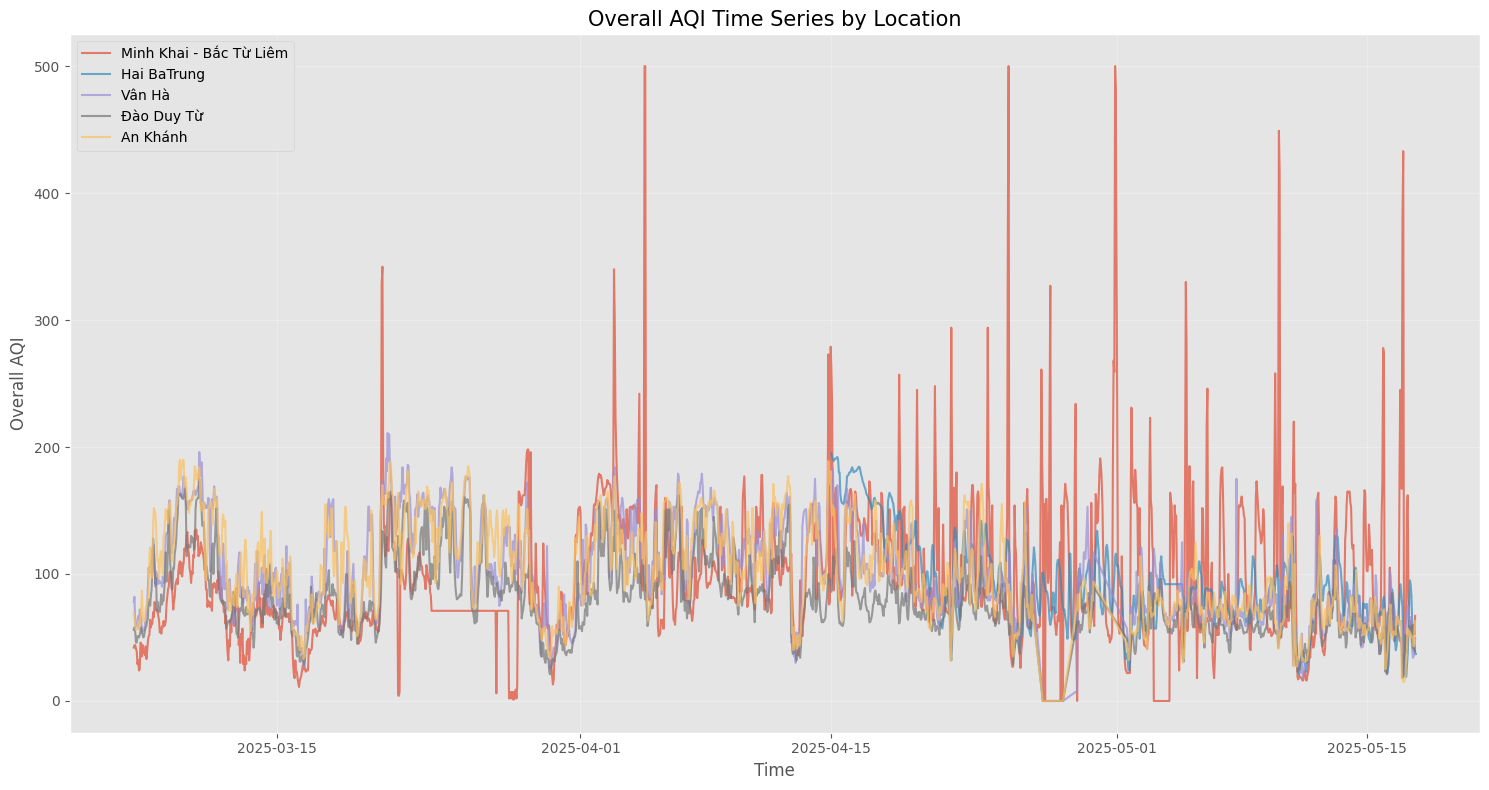

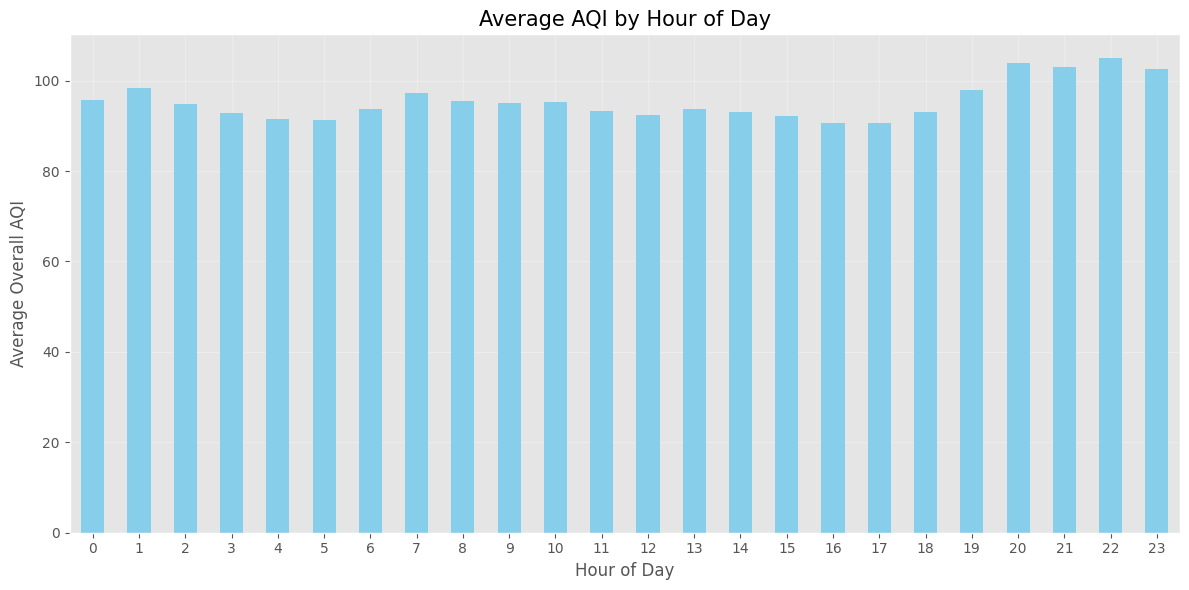

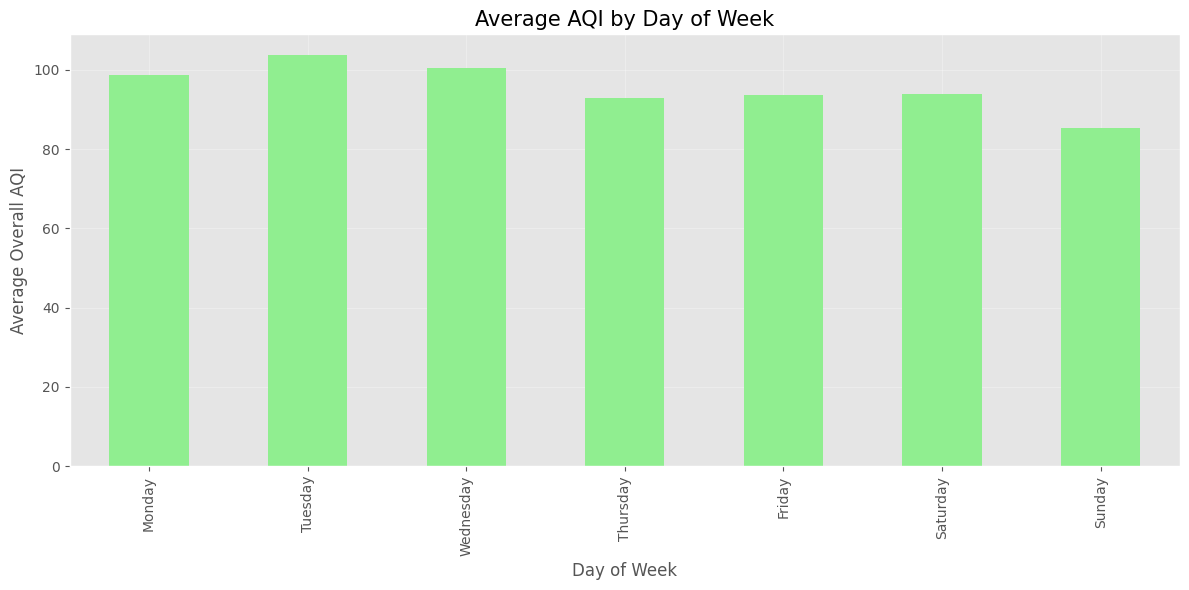

In [6]:
# Visualize AQI time series by location
plt.figure(figsize=(15, 8))

# Get top 5 locations with most data points
top_locations = historical_data['location'].value_counts().head(5).index.tolist()

for location in top_locations:
    location_data = historical_data[historical_data['location'] == location]
    plt.plot(location_data['time'], location_data['overall_aqi'], label=location, alpha=0.7)

plt.title('Overall AQI Time Series by Location', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Overall AQI', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Daily and hourly patterns
# Create time-based features
historical_data['hour'] = historical_data['time'].dt.hour
historical_data['day_of_week'] = historical_data['time'].dt.dayofweek
historical_data['month'] = historical_data['time'].dt.month

# Hourly patterns
plt.figure(figsize=(12, 6))
hourly_aqi = historical_data.groupby('hour')['overall_aqi'].mean()
hourly_aqi.plot(kind='bar', color='skyblue')
plt.title('Average AQI by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Overall AQI', fontsize=12)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Day of week patterns
plt.figure(figsize=(12, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_aqi = historical_data.groupby('day_of_week')['overall_aqi'].mean()
daily_aqi.index = day_names
daily_aqi.plot(kind='bar', color='lightgreen')
plt.title('Average AQI by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Overall AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

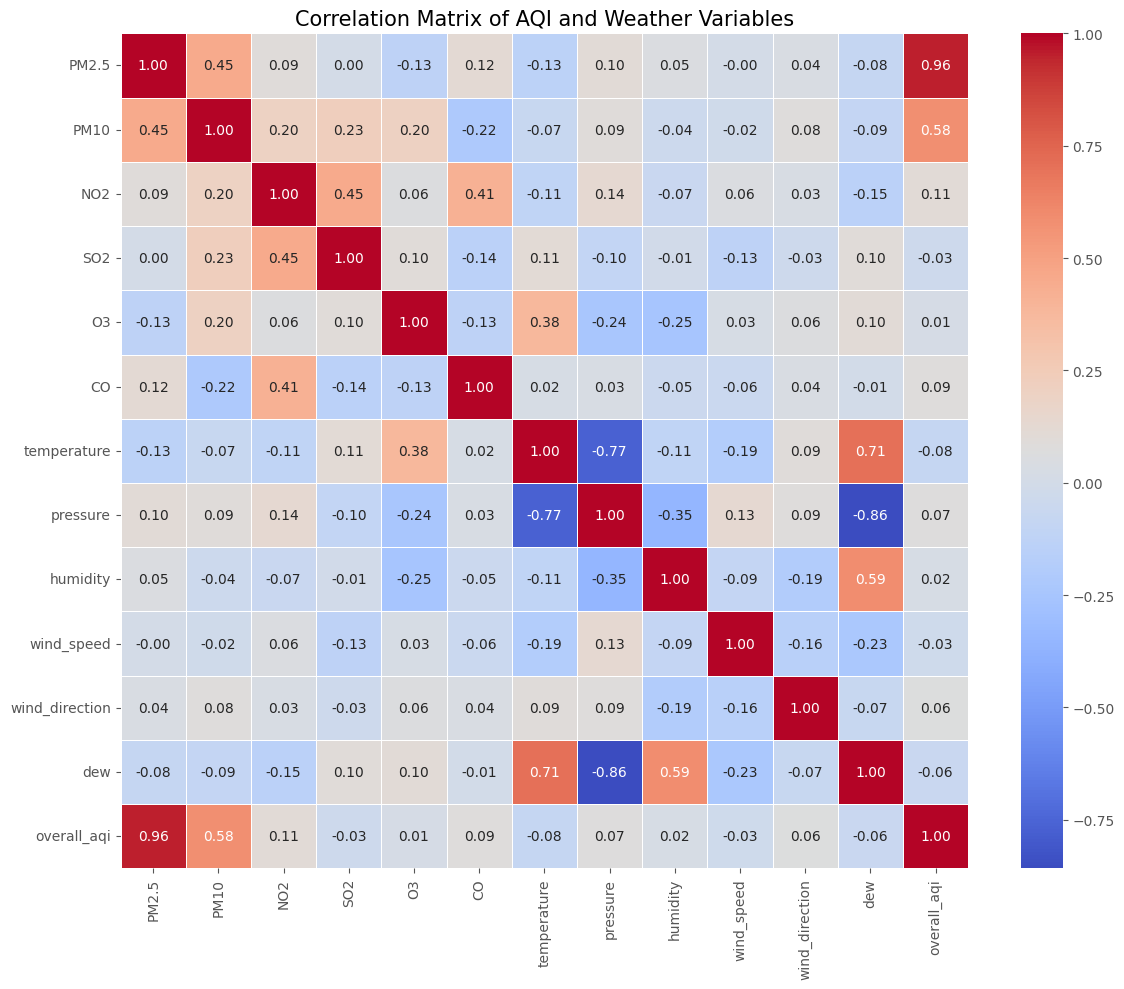

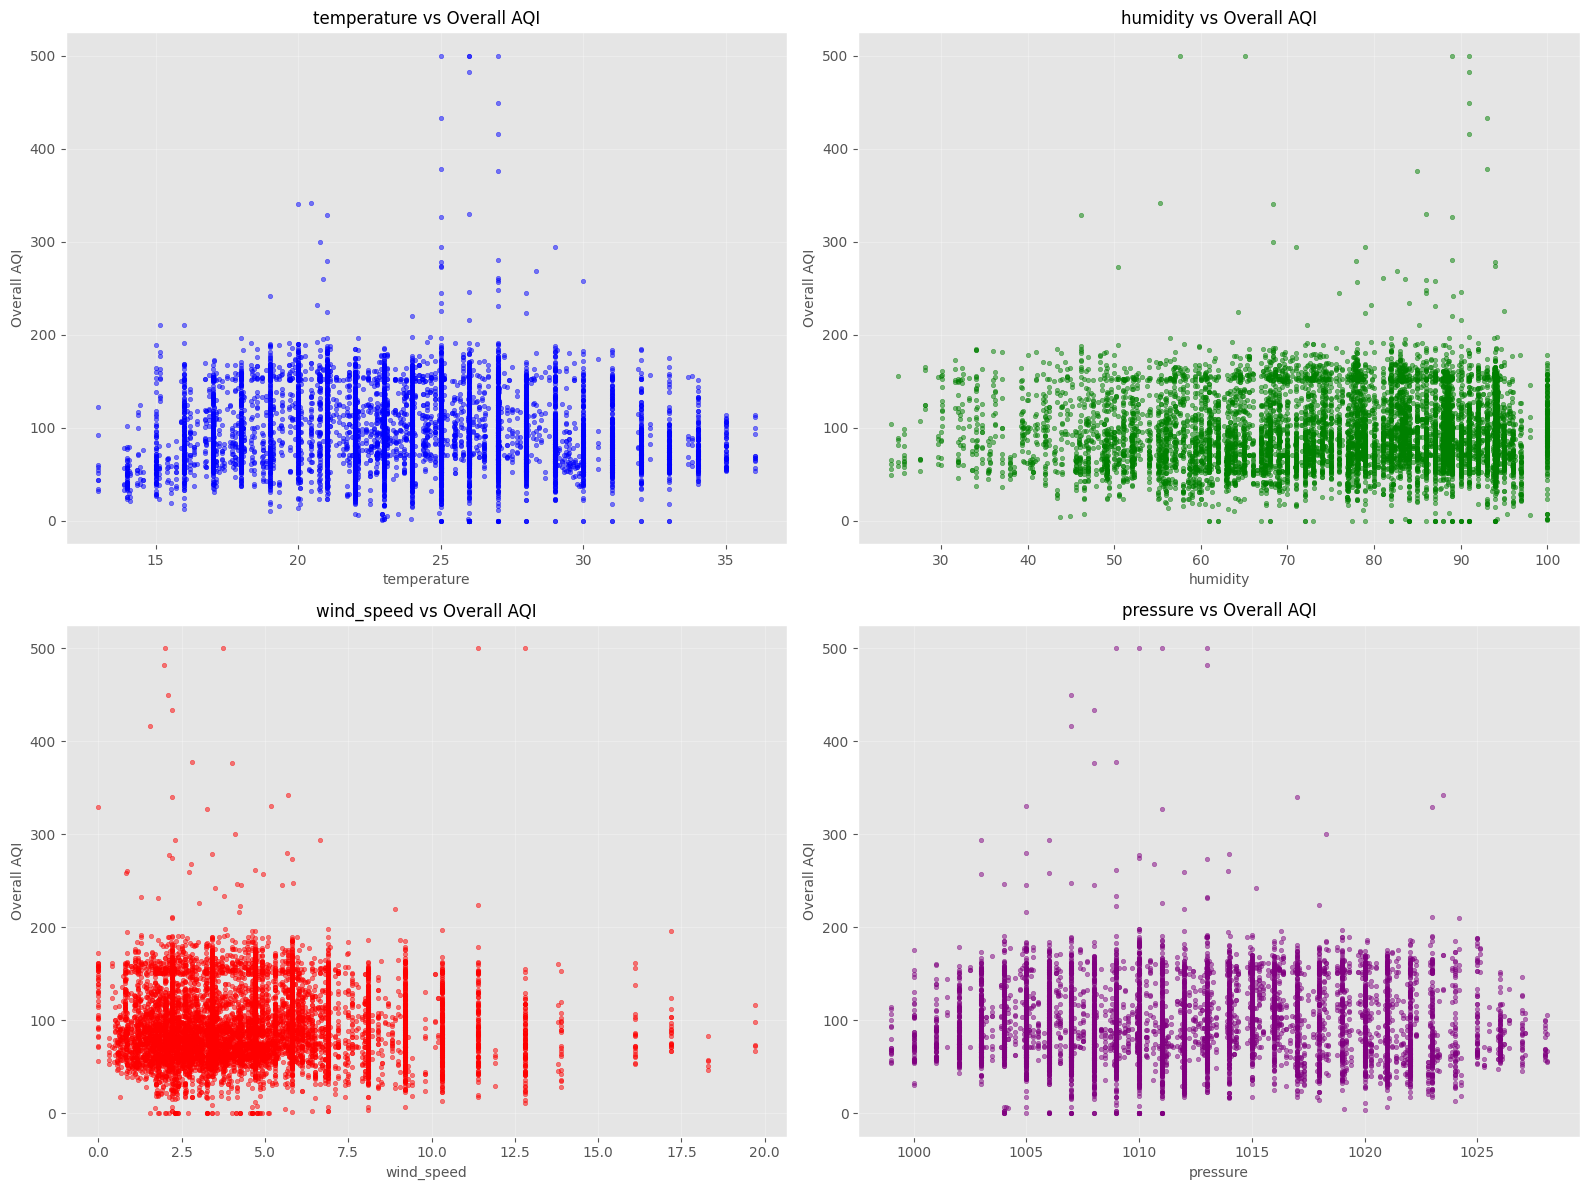

In [7]:
# Correlation analysis
# Select numeric columns for correlation
numeric_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 
                'temperature', 'pressure', 'humidity', 
                'wind_speed', 'wind_direction', 'dew', 'overall_aqi']

# Compute correlation matrix
corr_matrix = historical_data[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of AQI and Weather Variables', fontsize=15)
plt.tight_layout()
plt.show()

# Scatter plots for key relationships
plt.figure(figsize=(16, 12))

# Variables to compare with AQI
vars_to_plot = ['temperature', 'humidity', 'wind_speed', 'pressure']
colors = ['blue', 'green', 'red', 'purple']

for i, var in enumerate(vars_to_plot):
    plt.subplot(2, 2, i+1)
    plt.scatter(historical_data[var], historical_data['overall_aqi'], 
                alpha=0.5, color=colors[i], s=10)
    plt.title(f'{var} vs Overall AQI', fontsize=12)
    plt.xlabel(var, fontsize=10)
    plt.ylabel('Overall AQI', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add regression line
    if historical_data[var].notna().sum() > 0:
        m, b = np.polyfit(historical_data[var].dropna(), 
                        historical_data.loc[historical_data[var].notna(), 'overall_aqi'], 1)
        plt.plot(historical_data[var].dropna(), m*historical_data[var].dropna() + b, 'k--', lw=2)

plt.tight_layout()
plt.show()

Performing time series decomposition for location: Minh Khai - Bắc Từ Liêm


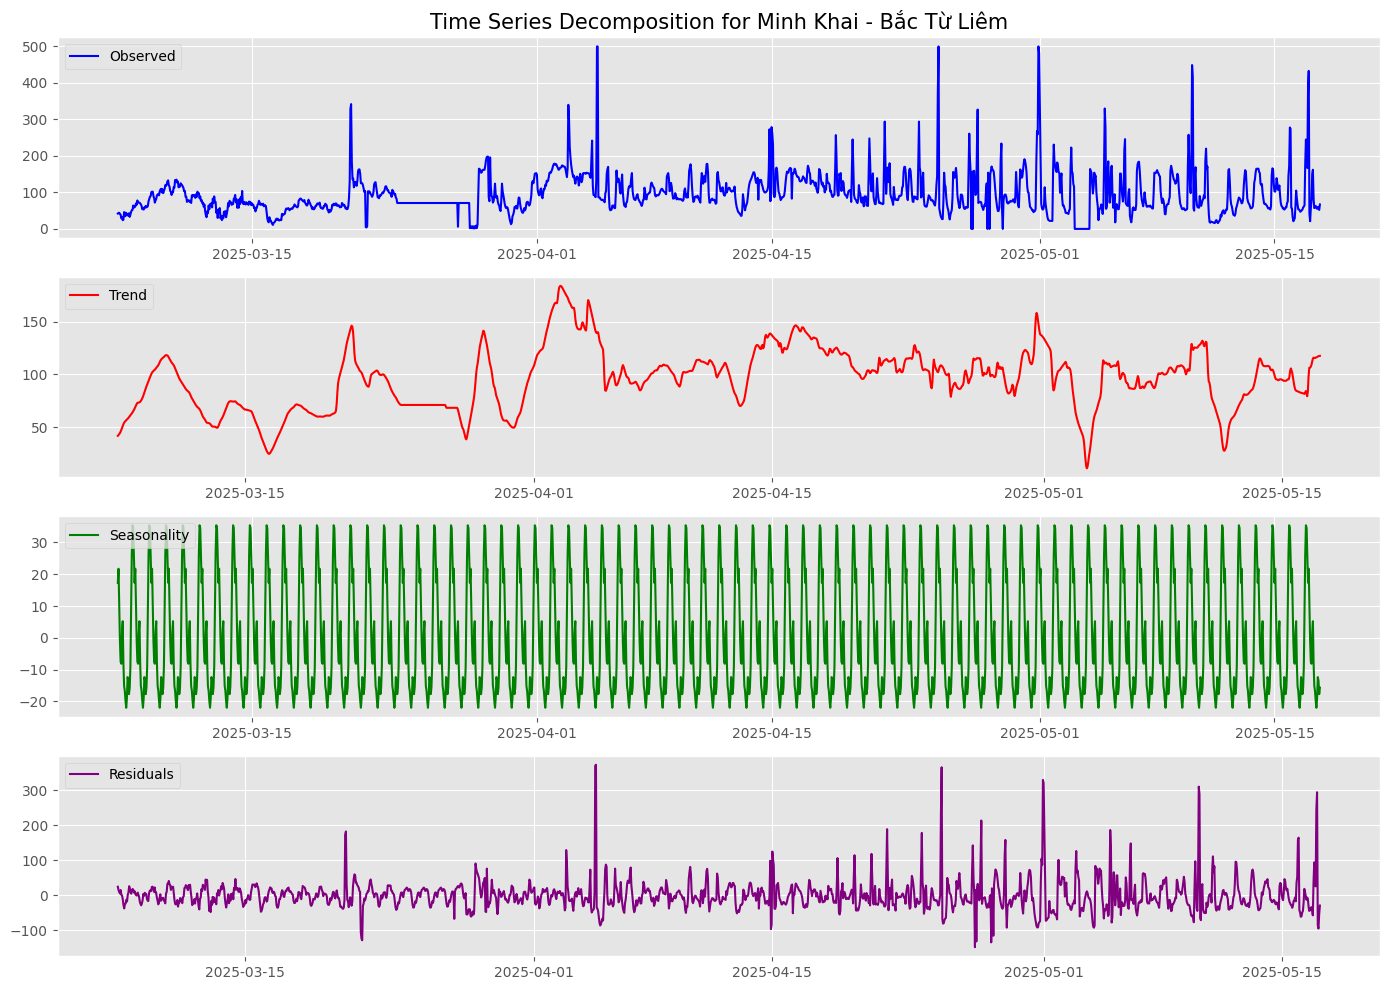

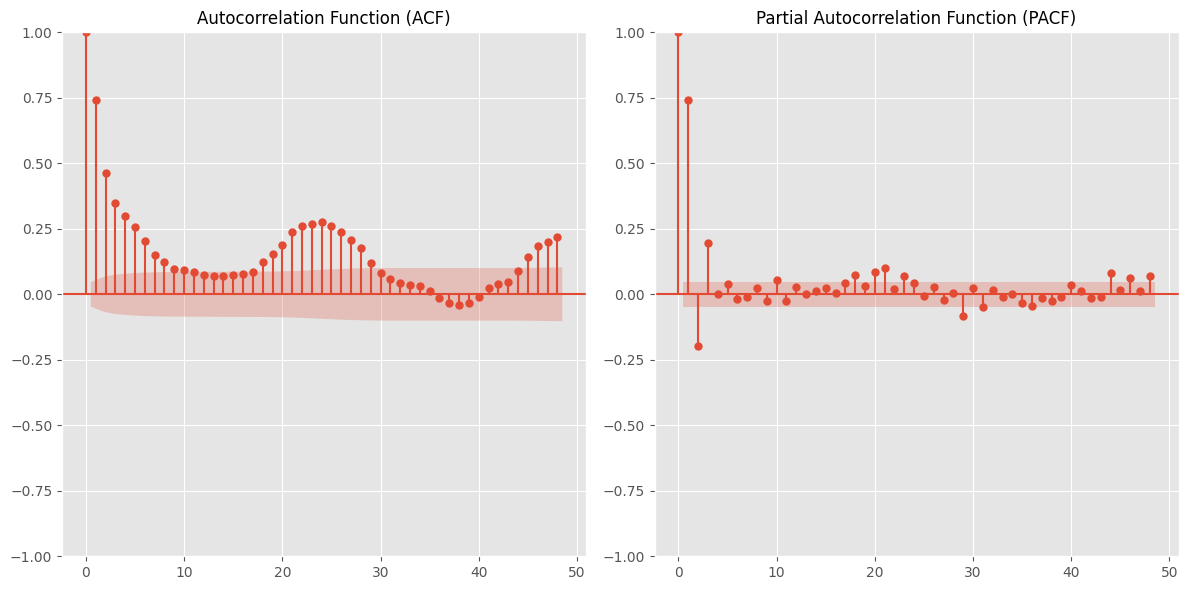

In [8]:
# Time series decomposition for a specific location
# Let's choose a location with complete data
target_location = historical_data['location'].value_counts().index[0]
print(f"Performing time series decomposition for location: {target_location}")

# Filter to one location and set time as index
location_data = historical_data[historical_data['location'] == target_location].copy()
location_data = location_data.set_index('time').sort_index()

# Resample to hourly frequency (in case there are missing values)
hourly_data = location_data['overall_aqi'].resample('H').mean()

# Fill any missing values with interpolation for decomposition
hourly_data = hourly_data.interpolate(method='time')

# Decompose the time series
try:
    # Seasonal decomposition
    decomposition = seasonal_decompose(hourly_data, model='additive', period=24)
    
    # Plot the decomposition
    plt.figure(figsize=(14, 10))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed', color='blue')
    plt.legend(loc='upper left')
    plt.title(f'Time Series Decomposition for {target_location}', fontsize=15)
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='purple')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(hourly_data.dropna(), lags=48, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)', fontsize=12)
    
    plt.subplot(122)
    plot_pacf(hourly_data.dropna(), lags=48, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in time series decomposition: {e}")
    print("Make sure you have enough data points and no gaps in your time series.")

## 4. Data Preprocessing

We'll prepare the data for modeling by handling missing values, encoding categorical features, and creating a proper time series dataset.

In [9]:
# Use all locations for modeling
# Instead of selecting a single location, we'll use data from all locations
print(f"Number of unique locations: {historical_data['location'].nunique()}")
print(f"Locations: {', '.join(historical_data['location'].unique())}")

# Create a copy of all data
location_data = historical_data.copy().reset_index(drop=True)

# Sort by location and time to ensure chronological order within each location
location_data = location_data.sort_values(['location', 'time']).reset_index(drop=True)

# Display basic info about the data
print(f"Total number of records across all locations: {len(location_data)}")
print(f"Date range: {location_data['time'].min()} to {location_data['time'].max()}")
print(f"Overall AQI range: {location_data['overall_aqi'].min()} - {location_data['overall_aqi'].max()}")

# Check number of records per location
location_counts = location_data['location'].value_counts()
print("Records per location:")
display(location_counts)

# Check for missing values in the dataset
missing_values = location_data.isna().sum()
missing_percentage = (missing_values / len(location_data)) * 100

# Create a DataFrame for better visualization
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Display missing values
display(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

SyntaxError: EOL while scanning string literal (2207002999.py, line 19)

In [ ]:
# Handle missing values
# For numerical columns, use interpolation
numeric_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 
                'temperature', 'pressure', 'humidity', 
                'wind_speed', 'wind_direction', 'dew', 'overall_aqi']

# First, ensure 'time' is a datetime
location_data['time'] = pd.to_datetime(location_data['time'])

# Initial check for infinite or extremely large values
for col in numeric_cols:
    # Replace infinities with NaN
    if (location_data[col] == np.inf).any() or (location_data[col] == -np.inf).any():
        print(f"Found infinite values in {col}, replacing with NaN")
        location_data[col] = location_data[col].replace([np.inf, -np.inf], np.nan)
    
    # Check for extreme outliers and cap them
    if col in location_data.columns:
        q1 = location_data[col].quantile(0.01)
        q3 = location_data[col].quantile(0.99)
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        
        # Identify extreme outliers
        extreme_mask = (location_data[col] < lower_bound) | (location_data[col] > upper_bound)
        extreme_count = extreme_mask.sum()
        
        if extreme_count > 0:
            print(f"Found {extreme_count} extreme outliers in {col}, capping values")
            location_data.loc[location_data[col] < lower_bound, col] = lower_bound
            location_data.loc[location_data[col] > upper_bound, col] = upper_bound

# Handle missing values for each location separately
for location in location_data['location'].unique():
    # Filter for the current location
    loc_mask = location_data['location'] == location
    
    # Get the data for this location and set time as index
    loc_data = location_data[loc_mask].set_index('time')
    
    # Interpolate numeric columns for this location
    for col in numeric_cols:
        if col in loc_data.columns and loc_data[col].isna().any():
            # Linear interpolation for missing values
            loc_data[col] = loc_data[col].interpolate(method='time')
            
            # Forward/backward fill any remaining NAs at edges
            loc_data[col] = loc_data[col].fillna(method='ffill').fillna(method='bfill')
    
    # Handle weather_icon (categorical) for this location
    if 'weather_icon' in loc_data.columns and loc_data['weather_icon'].isna().any():
        # Fill with mode (most common value) for this location
        most_common = loc_data['weather_icon'].mode()[0]
        loc_data['weather_icon'] = loc_data['weather_icon'].fillna(most_common)
    
    # Update the values in the original dataframe
    location_data.loc[loc_mask, loc_data.columns] = loc_data.values

# Reset index if it was modified
if location_data.index.name == 'time':
    location_data = location_data.reset_index()

# Final check for any remaining missing values and fill them
remaining_nulls = location_data[numeric_cols].isnull().sum()
if remaining_nulls.sum() > 0:
    print("Some missing values could not be interpolated. Using column means to fill remaining NaNs.")
    
    for col in numeric_cols:
        if location_data[col].isna().sum() > 0:
            # For each location, fill with the location mean
            for location in location_data['location'].unique():
                loc_mask = location_data['location'] == location
                loc_mean = location_data.loc[loc_mask, col].mean()
                
                # If the location mean is NaN (all values missing), use global mean
                if pd.isna(loc_mean):
                    loc_mean = location_data[col].mean()
                    
                # If even the global mean is NaN, use 0
                if pd.isna(loc_mean):
                    loc_mean = 0
                    
                # Fill missing values for this location
                location_data.loc[loc_mask & location_data[col].isna(), col] = loc_mean

# Check if we've successfully handled all missing values
remaining_missing = location_data.isna().sum().sum()
print(f"Remaining missing values after preprocessing: {remaining_missing}")

# Final verification for no NaN values
if remaining_missing > 0:
    print("WARNING: Some missing values still remain. Performing final cleanup.")
    # Identify columns with remaining missing values
    cols_with_missing = location_data.columns[location_data.isna().any()].tolist()
    print(f"Columns with missing values: {cols_with_missing}")
    
    # Fill any remaining NaNs (as a last resort)
    location_data = location_data.fillna(0)
    
    # Verify no NaNs remain
    final_check = location_data.isna().sum().sum()
    print(f"Final missing value count: {final_check}")

# Verify data is complete for the overall_aqi (our target variable)
print(f"Missing values in overall_aqi: {location_data['overall_aqi'].isna().sum()}")

In [ ]:
# Encode categorical variables
# For weather_icon, we'll use one-hot encoding
if 'weather_icon' in location_data.columns:
    # Extract first 2 characters (main weather condition code)
    location_data['weather_condition'] = location_data['weather_icon'].str[:2]
    
    # One-hot encode the weather condition
    weather_dummies = pd.get_dummies(location_data['weather_condition'], prefix='weather')
    
    # Concatenate with the original dataframe
    location_data = pd.concat([location_data, weather_dummies], axis=1)
    
    print(f"Created {len(weather_dummies.columns)} weather condition dummy variables")

# One-hot encode the location (important for the multi-location model)
location_dummies = pd.get_dummies(location_data['location'], prefix='location')
location_data = pd.concat([location_data, location_dummies], axis=1)
print(f"Created {len(location_dummies.columns)} location dummy variables")

# Extract time-based features
location_data['hour'] = location_data['time'].dt.hour
location_data['day_of_week'] = location_data['time'].dt.dayofweek
location_data['month'] = location_data['time'].dt.month
location_data['day_of_year'] = location_data['time'].dt.dayofyear
location_data['is_weekend'] = location_data['day_of_week'].isin([5, 6]).astype(int)

# Create cyclical features for time variables
# This preserves the cyclical nature of time features
location_data['hour_sin'] = np.sin(2 * np.pi * location_data['hour']/24)
location_data['hour_cos'] = np.cos(2 * np.pi * location_data['hour']/24)
location_data['month_sin'] = np.sin(2 * np.pi * location_data['month']/12)
location_data['month_cos'] = np.cos(2 * np.pi * location_data['month']/12)
location_data['day_of_week_sin'] = np.sin(2 * np.pi * location_data['day_of_week']/7)
location_data['day_of_week_cos'] = np.cos(2 * np.pi * location_data['day_of_week']/7)
location_data['wind_direction_sin'] = np.sin(2 * np.pi * location_data['wind_direction']/360)
location_data['wind_direction_cos'] = np.cos(2 * np.pi * location_data['wind_direction']/360)

print("Created cyclical time-based features")

# Display the final preprocessed dataset
print(f"Final dataset shape: {location_data.shape}")
display(location_data.head())

## 5. Feature Engineering for Time Series Forecasting

We'll create lagged features and rolling window statistics to capture temporal patterns in the data. This is crucial for forecasting future values.

In [ ]:
# Create a function to generate features for time series forecasting
def create_time_series_features(df, target_col='overall_aqi', lag_hours=[1, 2, 3, 6, 12, 24], 
                              rolling_windows=[3, 6, 12, 24]):
    """
    Create time series features including:
    - Lagged values (previous hours)
    - Rolling statistics (mean, std, min, max)
    - Time-based features (already created in preprocessing)
    
    Args:
        df: DataFrame with time series data (sorted by location and time)
        target_col: Column to create features for
        lag_hours: List of lag periods (in hours) to create
        rolling_windows: List of rolling window sizes for statistics
        
    Returns:
        DataFrame with additional features
    """
    # Create a copy to avoid modifying the original
    result_df = df.copy()
    
    # Process each location separately to maintain time series integrity
    for location in result_df['location'].unique():
        print(f"Creating time series features for location: {location}")
        
        # Filter for this location
        loc_mask = result_df['location'] == location
        
        # Get indices for this location
        loc_indices = result_df[loc_mask].index
        
        # Sort by time within each location
        loc_df = result_df.loc[loc_indices].sort_values('time')
        
        # Create lagged features
        for lag in lag_hours:
            # Calculate lag within this location's data
            lag_values = loc_df[target_col].shift(lag)
            # Assign back to the result dataframe
            result_df.loc[loc_indices, f'{target_col}_lag_{lag}h'] = lag_values.values
            print(f"Created {target_col}_lag_{lag}h feature for {location}")
        
        # Create rolling window statistics
        for window in rolling_windows:
            # Rolling mean
            roll_mean = loc_df[target_col].rolling(window=window).mean().shift(1)
            result_df.loc[loc_indices, f'{target_col}_rolling_mean_{window}h'] = roll_mean.values
            
            # Rolling standard deviation
            roll_std = loc_df[target_col].rolling(window=window).std().shift(1)
            result_df.loc[loc_indices, f'{target_col}_rolling_std_{window}h'] = roll_std.values
            
            # Rolling min and max
            roll_min = loc_df[target_col].rolling(window=window).min().shift(1)
            result_df.loc[loc_indices, f'{target_col}_rolling_min_{window}h'] = roll_min.values
            
            roll_max = loc_df[target_col].rolling(window=window).max().shift(1)
            result_df.loc[loc_indices, f'{target_col}_rolling_max_{window}h'] = roll_max.values
            
            print(f"Created rolling statistics with {window}h window for {location}")
        
        # Create lag differences (rate of change)
        for lag in lag_hours:
            if lag > 1:  # Skip lag 1 as it would be the same as regular lag
                diff_values = loc_df[target_col].diff(lag)
                result_df.loc[loc_indices, f'{target_col}_diff_{lag}h'] = diff_values.values
                print(f"Created difference feature: {target_col}_diff_{lag}h for {location}")
        
        # Create lagged features for weather variables
        weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']
        for var in weather_vars:
            if var in result_df.columns:
                # 1-hour and 24-hour lags for weather variables
                lag1_values = loc_df[var].shift(1)
                result_df.loc[loc_indices, f'{var}_lag_1h'] = lag1_values.values
                
                lag24_values = loc_df[var].shift(24)
                result_df.loc[loc_indices, f'{var}_lag_24h'] = lag24_values.values
                print(f"Created lagged features for {var} in {location}")
    
    # Add day/night indicator (6am-6pm is day, else night)
    result_df['is_daytime'] = ((result_df['hour'] >= 6) & (result_df['hour'] < 18)).astype(int)
    print("Added day/night indicator")
    
    return result_df

# Apply the feature engineering function
ts_features_df = create_time_series_features(location_data)

# Display the resulting dataset shape
print(f"Original dataset shape: {location_data.shape}")
print(f"Feature-engineered dataset shape: {ts_features_df.shape}")
print(f"Added {ts_features_df.shape[1] - location_data.shape[1]} new features")

# Display the first few rows of the feature-engineered dataset
display(ts_features_df.head())

# Check for missing values created by lag/rolling operations
missing_after_features = ts_features_df.isna().sum()
print(f"Columns with missing values after feature engineering: {sum(missing_after_features > 0)}")

In [ ]:
# Prepare the dataset for supervised learning
# We need to handle the NaN values created by lagging operations
# and split into training and validation sets respecting time order

# First, determine the maximum lag period
max_lag = 24  # Our maximum lag is 24 hours

# Instead of just dropping the first N rows, we need to filter per location
ts_features_clean = pd.DataFrame()

for location in ts_features_df['location'].unique():
    # Get data for this location
    loc_data = ts_features_df[ts_features_df['location'] == location].copy()
    
    # Sort by time
    loc_data = loc_data.sort_values('time')
    
    # Skip the first max_lag rows for this location (these will have NaN values)
    if len(loc_data) > max_lag:
        loc_data_clean = loc_data.iloc[max_lag:].copy()
        ts_features_clean = pd.concat([ts_features_clean, loc_data_clean])

# Reset index
ts_features_clean = ts_features_clean.reset_index(drop=True)

print(f"After removing initial rows with NaN values, we have {len(ts_features_clean)} records.")

# Check if we still have any NaN values
remaining_nans = ts_features_clean.isna().sum().sum()
print(f"Remaining NaN values after dropping initial rows: {remaining_nans}")

# If we still have NaN values, handle them
if remaining_nans > 0:
    # Identify columns with NaN values
    cols_with_nans = ts_features_clean.columns[ts_features_clean.isna().any()].tolist()
    print(f"Columns with remaining NaN values: {cols_with_nans}")
    
    # Process by location to maintain time series integrity
    for location in ts_features_clean['location'].unique():
        loc_mask = ts_features_clean['location'] == location
        
        # For each column with NaNs, fill with appropriate method
        for col in cols_with_nans:
            # For rolling statistics, forward fill
            if 'rolling' in col:
                ts_features_clean.loc[loc_mask, col] = ts_features_clean.loc[loc_mask, col].fillna(method='ffill')
            # For lag differences, use 0 (no change)
            elif 'diff' in col:
                ts_features_clean.loc[loc_mask, col] = ts_features_clean.loc[loc_mask, col].fillna(0)
            # For other features, use column mean for that location
            else:
                loc_mean = ts_features_clean.loc[loc_mask, col].mean()
                ts_features_clean.loc[loc_mask, col] = ts_features_clean.loc[loc_mask, col].fillna(loc_mean)

# Define features and target
target_col = 'overall_aqi'

# Features to exclude from the model
exclude_cols = ['time', 'location', 'weather_icon', 'weather_condition']

# Define features: all columns except target and excluded columns
features = [col for col in ts_features_clean.columns 
            if col != target_col and col not in exclude_cols]

print(f"Number of features for modeling: {len(features)}")

# Split into training and validation sets (80% train, 20% validation)
# We need to split by time for each location to respect chronological order
train_df = pd.DataFrame()
val_df = pd.DataFrame()

for location in ts_features_clean['location'].unique():
    # Get data for this location
    loc_data = ts_features_clean[ts_features_clean['location'] == location].copy()
    
    # Sort by time
    loc_data = loc_data.sort_values('time')
    
    # Calculate split point (80% train, 20% validation)
    train_size = int(len(loc_data) * 0.8)
    
    # Split the data
    loc_train = loc_data.iloc[:train_size]
    loc_val = loc_data.iloc[train_size:]
    
    # Add to the combined datasets
    train_df = pd.concat([train_df, loc_train])
    val_df = pd.concat([val_df, loc_val])

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Training period: {train_df['time'].min()} to {train_df['time'].max()}")
print(f"Validation period: {val_df['time'].min()} to {val_df['time'].max()}")

# Create X and y for both sets
X_train = train_df[features]
y_train = train_df[target_col]
X_val = val_df[features]
y_val = val_df[target_col]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled successfully")

## 6. Model Building

We'll train a single model using data from all locations to forecast AQI values. This unified model will learn patterns from across locations while still being able to generate location-specific forecasts.

In [ ]:
# First, check for any remaining NaN values in the training data
print("Checking for NaN values in the training data...")
nan_features = X_train.columns[X_train.isna().any()].tolist()
if nan_features:
    print(f"Found NaN values in features: {nan_features}")
    print("Filling NaN values with appropriate strategies")
    
    # Create a simple imputer to handle any remaining NaNs
    from sklearn.impute import SimpleImputer
    
    # For numeric features, use mean imputation
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    
    # Now scale the imputed data
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)
    
    # After imputation, verify no NaNs remain
    if np.isnan(X_train_scaled).any() or np.isnan(X_val_scaled).any():
        print("WARNING: NaN values still present after imputation!")
        # Force replace any remaining NaNs with zeros as a last resort
        X_train_scaled = np.nan_to_num(X_train_scaled)
        X_val_scaled = np.nan_to_num(X_val_scaled)
else:
    print("No NaN values found in features. Proceeding with training.")

# Verify we have data from all locations in both training and validation sets
train_locations = train_df['location'].unique()
val_locations = val_df['location'].unique()
print(f"Training set has data from {len(train_locations)} locations: {', '.join(train_locations)}")
print(f"Validation set has data from {len(val_locations)} locations: {', '.join(val_locations)}")

# Define a function to evaluate a model
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance using multiple metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Train and evaluate multiple models
models = {}
results = []

# 1. XGBoost Regressor - our baseline model
print("Training XGBoost model using data from all locations...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.08, 
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)
models['XGBoost'] = xgb_model
results.append(evaluate_model(y_val, xgb_pred, 'XGBoost'))

# 2. Random Forest Regressor
print("Training Random Forest model using data from all locations...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)
models['Random Forest'] = rf_model
results.append(evaluate_model(y_val, rf_pred, 'Random Forest'))

# 3. Gradient Boosting Regressor
print("Training Gradient Boosting model using data from all locations...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_val_scaled)
models['Gradient Boosting'] = gb_model
results.append(evaluate_model(y_val, gb_pred, 'Gradient Boosting'))

# Create a DataFrame with results
results_df = pd.DataFrame(results)
display(results_df)

# Visualize actual vs predicted values for the best model
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'model']
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Get predictions from the best model
if best_model_name == 'XGBoost':
    best_pred = xgb_pred
elif best_model_name == 'Random Forest':
    best_pred = rf_pred
else:
    best_pred = gb_pred

# Evaluate per location
print("\nEvaluating model performance for each location separately:")
for location in val_df['location'].unique():
    # Filter validation data for this location
    loc_mask = val_df['location'] == location
    loc_y_true = y_val[loc_mask]
    loc_y_pred = best_pred[loc_mask]
    
    # Calculate metrics for this location
    loc_mae = mean_absolute_error(loc_y_true, loc_y_pred)
    loc_rmse = np.sqrt(mean_squared_error(loc_y_true, loc_y_pred))
    loc_r2 = r2_score(loc_y_true, loc_y_pred)
    
    print(f"{location} - MAE: {loc_mae:.2f}, RMSE: {loc_rmse:.2f}, R²: {loc_r2:.3f}")

# Plot actual vs predicted by location
plt.figure(figsize=(16, 10))
num_locations = len(val_df['location'].unique())
cols = min(3, num_locations)
rows = (num_locations + cols - 1) // cols
colors = plt.cm.tab10(np.linspace(0, 1, num_locations))

for i, location in enumerate(val_df['location'].unique()):
    plt.subplot(rows, cols, i+1)
    
    # Filter data for this location
    loc_mask = val_df['location'] == location
    loc_times = val_df.loc[loc_mask, 'time']
    loc_y_true = y_val[loc_mask]
    loc_y_pred = best_pred[loc_mask]
    
    # Plot
    plt.plot(loc_times, loc_y_true, label='Actual', marker='o', markersize=3, 
             linestyle='-', linewidth=1, color=colors[i])
    plt.plot(loc_times, loc_y_pred, label='Predicted', marker='x', markersize=3, 
             linestyle='--', linewidth=1, color='gray')
    
    plt.title(f'{location}', fontsize=12)
    plt.xlabel('Time', fontsize=10)
    plt.ylabel('AQI', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, fontsize=8)
    
    # Add legend on first subplot only
    if i == 0:
        plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Check feature importance for tree-based models
if best_model_name in ['XGBoost', 'Random Forest', 'Gradient Boosting']:
    # Get feature importance
    if best_model_name == 'XGBoost':
        importance = best_model.feature_importances_
    else:
        importance = best_model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 most important features
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Check if location features are important
    loc_features = [f for f in feature_importance['Feature'] if f.startswith('location_')]
    if loc_features:
        loc_importance = feature_importance[feature_importance['Feature'].isin(loc_features)]
        
        print("\nLocation feature importance:")
        display(loc_importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=loc_importance)
        plt.title('Location Feature Importance', fontsize=15)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Location', fontsize=12)
        plt.tight_layout()
        plt.show()

In [ ]:
# Hyperparameter tuning for the best model
# We'll use TimeSeriesSplit for cross-validation to respect time order
print(f"Performing hyperparameter tuning for {best_model_name}...")

# Create time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameter grid based on the best model
if best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'subsample': [0.6, 0.8, 1.0]
    }
    model = xgb.XGBRegressor(random_state=42)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    
else:  # Gradient Boosting
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.6, 0.8, 1.0]
    }
    model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert back to RMSE

print(f"Best parameters: {best_params}")
print(f"Best cross-validation RMSE: {best_score:.2f}")

# Train a model with the best parameters
tuned_model = grid_search.best_estimator_
tuned_pred = tuned_model.predict(X_val_scaled)

# Evaluate the tuned model
tuned_results = evaluate_model(y_val, tuned_pred, f'Tuned {best_model_name}')

# Compare with the original model
print(f"Improvement: {results_df[results_df['model'] == best_model_name]['RMSE'].values[0] - tuned_results['RMSE']:.2f} RMSE")

# Save the best model
models['Tuned ' + best_model_name] = tuned_model

# Evaluate tuned model per location
print("\nEvaluating tuned model performance for each location separately:")
for location in val_df['location'].unique():
    # Filter validation data for this location
    loc_mask = val_df['location'] == location
    loc_y_true = y_val[loc_mask]
    loc_y_pred = tuned_pred[loc_mask]
    
    # Calculate metrics for this location
    loc_mae = mean_absolute_error(loc_y_true, loc_y_pred)
    loc_rmse = np.sqrt(mean_squared_error(loc_y_true, loc_y_pred))
    loc_r2 = r2_score(loc_y_true, loc_y_pred)
    
    print(f"{location} - MAE: {loc_mae:.2f}, RMSE: {loc_rmse:.2f}, R²: {loc_r2:.3f}")

# Plot actual vs predicted for the tuned model by location
plt.figure(figsize=(16, 10))
num_locations = len(val_df['location'].unique())
cols = min(3, num_locations)
rows = (num_locations + cols - 1) // cols

for i, location in enumerate(val_df['location'].unique()):
    plt.subplot(rows, cols, i+1)
    
    # Filter data for this location
    loc_mask = val_df['location'] == location
    loc_times = val_df.loc[loc_mask, 'time']
    loc_y_true = y_val[loc_mask]
    loc_y_pred = tuned_pred[loc_mask]
    
    # Plot
    plt.plot(loc_times, loc_y_true, label='Actual', marker='o', markersize=3, 
             linestyle='-', linewidth=1, color=colors[i])
    plt.plot(loc_times, loc_y_pred, label='Predicted (Tuned)', marker='x', markersize=3, 
             linestyle='--', linewidth=1, color='gray')
    
    plt.title(f'{location} - Tuned Model', fontsize=12)
    plt.xlabel('Time', fontsize=10)
    plt.ylabel('AQI', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, fontsize=8)
    
    # Add legend on first subplot only
    if i == 0:
        plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 7. Model Evaluation

Let's evaluate our best model thoroughly and understand its strengths and limitations.

In [ ]:
# Error analysis for the tuned model
final_model_name = f'Tuned {best_model_name}'
final_model = models[final_model_name]
final_pred = tuned_model.predict(X_val_scaled)

# Calculate errors
errors = y_val - final_pred
abs_errors = np.abs(errors)

# Create a DataFrame to analyze errors
error_df = pd.DataFrame({
    'Time': val_df['time'],
    'Actual': y_val,
    'Predicted': final_pred,
    'Error': errors,
    'Abs_Error': abs_errors,
    'Hour': val_df['hour'],
    'Day_of_Week': val_df['day_of_week']
})

# Display basic error statistics
print("Error Statistics:")
print(f"Mean Error: {errors.mean():.2f}")
print(f"Mean Absolute Error: {abs_errors.mean():.2f}")
print(f"Standard Deviation of Error: {errors.std():.2f}")
print(f"Min Error: {errors.min():.2f}")
print(f"Max Error: {errors.max():.2f}")

# Visualize error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7, color='blue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Error Distribution', fontsize=15)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze errors by time patterns
# By hour of day
hourly_errors = error_df.groupby('Hour')['Abs_Error'].mean()

plt.figure(figsize=(12, 6))
plt.bar(hourly_errors.index, hourly_errors.values, color='skyblue')
plt.title('Mean Absolute Error by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# By day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_errors = error_df.groupby('Day_of_Week')['Abs_Error'].mean()
daily_errors.index = day_names

plt.figure(figsize=(12, 6))
plt.bar(daily_errors.index, daily_errors.values, color='lightgreen')
plt.title('Mean Absolute Error by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error vs Actual Value (to check for systematic bias)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, errors, alpha=0.5, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title('Error vs Actual AQI', fontsize=15)
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Identify largest errors
largest_errors = error_df.sort_values('Abs_Error', ascending=False).head(10)
print("Top 10 largest prediction errors:")
display(largest_errors)

# Save the final model
final_model_info = {
    'model': final_model,
    'features': features,
    'scaler': scaler,
    'metrics': {
        'mae': mean_absolute_error(y_val, final_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, final_pred)),
        'r2': r2_score(y_val, final_pred)
    }
}

print(f"Final model saved: {final_model_name}")
print(f"Final model performance: MAE={final_model_info['metrics']['mae']:.2f}, RMSE={final_model_info['metrics']['rmse']:.2f}")

## 8. Forecasting the Next 24 Hours

Now we'll use our model to forecast AQI values for the next 24 hours for all locations.

In [ ]:
# Create a function to generate forecast for the next 24 hours for all locations
def forecast_next_24h(model, location_df, features, scaler, locations=None, target_col='overall_aqi'):
    """
    Generate forecasts for the next 24 hours using the trained model for multiple locations.
    
    Args:
        model: Trained model
        location_df: DataFrame with historical data
        features: List of feature columns
        scaler: Fitted StandardScaler
        locations: List of specific locations to forecast for, or None for all
        target_col: Target column name
        
    Returns:
        DataFrame with forecasted values for all locations
    """
    # If no locations specified, use all available
    if locations is None:
        locations = location_df['location'].unique()
    
    print(f"Generating forecasts for {len(locations)} locations: {', '.join(locations)}")
    
    # Store forecasts for all locations
    all_forecasts = []
    
    # Process each location separately
    for location in locations:
        print(f"Forecasting for location: {location}")
        
        # Make a copy of the data for this location
        forecast_df = location_df[location_df['location'] == location].copy().sort_values('time')
        
        # Get the latest time in the dataset for this location
        latest_time = forecast_df['time'].max()
        print(f"Latest time for {location}: {latest_time}")
        
        # Create a dataframe for the next 24 hours
        next_hours = pd.date_range(start=latest_time, periods=25, freq='H')[1:]  # Skip first as it's latest time
        
        # Create forecast dataframe
        next_24h_df = pd.DataFrame({'time': next_hours})
        next_24h_df['location'] = location
        
        # Generate time-based features
        next_24h_df['hour'] = next_24h_df['time'].dt.hour
        next_24h_df['day_of_week'] = next_24h_df['time'].dt.dayofweek
        next_24h_df['month'] = next_24h_df['time'].dt.month
        next_24h_df['day_of_year'] = next_24h_df['time'].dt.dayofyear
        next_24h_df['is_weekend'] = next_24h_df['day_of_week'].isin([5, 6]).astype(int)
        
        # Create cyclical features
        next_24h_df['hour_sin'] = np.sin(2 * np.pi * next_24h_df['hour']/24)
        next_24h_df['hour_cos'] = np.cos(2 * np.pi * next_24h_df['hour']/24)
        next_24h_df['month_sin'] = np.sin(2 * np.pi * next_24h_df['month']/12)
        next_24h_df['month_cos'] = np.cos(2 * np.pi * next_24h_df['month']/12)
        next_24h_df['day_of_week_sin'] = np.sin(2 * np.pi * next_24h_df['day_of_week']/7)
        next_24h_df['day_of_week_cos'] = np.cos(2 * np.pi * next_24h_df['day_of_week']/7)
        
        # Add location dummy variables
        for loc in locations:
            col_name = f'location_{loc}'
            next_24h_df[col_name] = 0
        
        # Set the correct location to 1
        next_24h_df[f'location_{location}'] = 1
        
        # For simplicity, copy the latest weather values to all forecast hours
        # In a real-world scenario, you'd use weather forecasts instead
        latest_row = forecast_df.iloc[-1]
        weather_vars = ['temperature', 'pressure', 'humidity', 'wind_speed', 
                        'wind_direction', 'dew', 'weather_condition']
                        
        for var in weather_vars:
            if var in forecast_df.columns:
                next_24h_df[var] = latest_row[var]
        
        # Generate wind direction cyclical features
        if 'wind_direction' in next_24h_df.columns:
            next_24h_df['wind_direction_sin'] = np.sin(2 * np.pi * next_24h_df['wind_direction']/360)
            next_24h_df['wind_direction_cos'] = np.cos(2 * np.pi * next_24h_df['wind_direction']/360)
        
        # Add weather dummies if they exist in the original data
        weather_dummies = [col for col in forecast_df.columns if col.startswith('weather_')]
        for col in weather_dummies:
            if col in latest_row:
                next_24h_df[col] = latest_row[col]
        
        # For is_daytime
        next_24h_df['is_daytime'] = ((next_24h_df['hour'] >= 6) & (next_24h_df['hour'] < 18)).astype(int)
        
        # Iteratively forecast each hour
        # Start with the historical data to get lagged values
        combined_df = pd.concat([forecast_df, next_24h_df], ignore_index=True)
        
        # Make 24 predictions, one for each hour
        for i in range(1, 25):
            # Index for the hour we're predicting
            pred_idx = len(forecast_df) + i - 1
            
            # Generate lagged features for the prediction hour
            lag_hours = [1, 2, 3, 6, 12, 24]
            rolling_windows = [3, 6, 12, 24]
            
            # Create lagged values
            for lag in lag_hours:
                combined_df.loc[pred_idx, f'{target_col}_lag_{lag}h'] = combined_df.loc[pred_idx - lag, target_col]
            
            # Create rolling window features
            for window in rolling_windows:
                # Use historical values for rolling statistics
                window_data = combined_df.loc[max(0, pred_idx - window):pred_idx - 1, target_col]
                
                combined_df.loc[pred_idx, f'{target_col}_rolling_mean_{window}h'] = window_data.mean()
                combined_df.loc[pred_idx, f'{target_col}_rolling_std_{window}h'] = window_data.std()
                combined_df.loc[pred_idx, f'{target_col}_rolling_min_{window}h'] = window_data.min()
                combined_df.loc[pred_idx, f'{target_col}_rolling_max_{window}h'] = window_data.max()
            
            # Create lag differences
            for lag in lag_hours:
                if lag > 1:
                    combined_df.loc[pred_idx, f'{target_col}_diff_{lag}h'] = (
                        combined_df.loc[pred_idx - 1, target_col] - 
                        combined_df.loc[pred_idx - lag, target_col]
                    )
            
            # Create lagged weather features
            weather_vars = ['temperature', 'humidity', 'pressure', 'wind_speed']
            for var in weather_vars:
                if var in combined_df.columns:
                    combined_df.loc[pred_idx, f'{var}_lag_1h'] = combined_df.loc[pred_idx - 1, var]
                    combined_df.loc[pred_idx, f'{var}_lag_24h'] = combined_df.loc[pred_idx - 24, var]
            
            # Extract features for prediction
            X_pred = combined_df.loc[pred_idx:pred_idx, features]
            
            # Check for and handle any missing values
            if X_pred.isna().any().any():
                print(f"Warning: NaN values found in prediction features for hour {i}. Handling missing values.")
                
                # Use the same imputer that was used during training (if available)
                if 'imputer' in globals():
                    X_pred_imputed = imputer.transform(X_pred)
                else:
                    # Otherwise, replace with 0 as a fallback
                    X_pred_imputed = X_pred.fillna(0).values
                
                # Scale features
                X_pred_scaled = scaler.transform(X_pred_imputed)
            else:
                # Scale features
                X_pred_scaled = scaler.transform(X_pred)
            
            # Handle any remaining NaNs (just in case)
            X_pred_scaled = np.nan_to_num(X_pred_scaled)
            
            # Make prediction
            prediction = model.predict(X_pred_scaled)[0]
            
            # Store prediction
            combined_df.loc[pred_idx, target_col] = prediction
        
        # Extract forecast data for this location
        forecast_result = combined_df.iloc[-24:][['time', 'location', target_col]].copy()
        forecast_result.rename(columns={target_col: 'forecast'}, inplace=True)
        
        # Add to the all locations results
        all_forecasts.append(forecast_result)
    
    # Combine all location forecasts
    combined_forecast = pd.concat(all_forecasts, ignore_index=True)
    return combined_forecast

# Generate forecast for the next 24 hours for all locations
try:
    forecast_df = forecast_next_24h(
        model=final_model,
        location_df=ts_features_clean,
        features=features,
        scaler=scaler
    )
    
    print("Forecast for the next 24 hours across all locations:")
    display(forecast_df)
    
    # Visualize the forecast for each location
    plt.figure(figsize=(14, 10))
    
    # Get unique locations in the forecast
    forecast_locations = forecast_df['location'].unique()
    
    # Create a subplot for each location
    n_locations = len(forecast_locations)
    n_cols = min(3, n_locations)  # Max 3 columns
    n_rows = (n_locations + n_cols - 1) // n_cols  # Ceiling division
    
    # Define colors for each location
    colors = plt.cm.tab10(np.linspace(0, 1, n_locations))
    
    for i, location in enumerate(forecast_locations):
        # Create subplot
        plt.subplot(n_rows, n_cols, i+1)
        
        # Get forecast for this location
        loc_forecast = forecast_df[forecast_df['location'] == location]
        
        # Get historical data for context (last 48 hours)
        loc_historical = ts_features_clean[ts_features_clean['location'] == location].sort_values('time').iloc[-48:]
        
        # Plot forecast
        plt.plot(loc_forecast['time'], loc_forecast['forecast'], 
                marker='o', linestyle='-', linewidth=2, color=colors[i], label='Forecast')
        
        # Plot historical data
        plt.plot(loc_historical['time'], loc_historical['overall_aqi'], 
                marker='x', linestyle='--', linewidth=1, color='gray', alpha=0.7, label='Historical')
        
        # Add vertical line at forecast start
        plt.axvline(x=loc_forecast['time'].min(), color='red', linestyle='--', linewidth=1)
        
        # Set title and labels
        plt.title(f'AQI Forecast: {location}', fontsize=12)
        plt.xlabel('Time', fontsize=10)
        plt.ylabel('AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis to show hours
        plt.gca().xaxis.set_major_formatter(DateFormatter('%m-%d %Hh'))
        plt.xticks(rotation=45, fontsize=8)
        
        # Add legend on the first subplot only
        if i == 0:
            plt.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Create a combined line plot for all locations
    plt.figure(figsize=(14, 7))
    
    for i, location in enumerate(forecast_locations):
        # Get forecast for this location
        loc_forecast = forecast_df[forecast_df['location'] == location]
        
        # Plot with unique color and marker
        plt.plot(loc_forecast['time'], loc_forecast['forecast'], 
                marker='o', linestyle='-', linewidth=2, color=colors[i], label=location)
    
    # Add vertical line at forecast start
    plt.axvline(x=forecast_df['time'].min(), color='black', linestyle='--', linewidth=1)
    plt.text(forecast_df['time'].min(), plt.ylim()[1]*0.95, 'Forecast Start', 
             ha='center', va='top', backgroundcolor='white')
    
    # Set title and labels
    plt.title('AQI Forecast for All Locations (Next 24 Hours)', fontsize=15)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('AQI', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Location')
    
    # Format x-axis to show hours
    plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d %Hh'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error generating forecast: {e}")
    print("Please ensure your data is complete and model is trained correctly.")

## 9. Visualization and Dashboard Elements

Let's create visualizations that could be part of a monitoring dashboard.

In [ ]:
# Create dashboard elements for AQI monitoring and forecasting
# 1. Current AQI gauge chart
from matplotlib.patches import Circle, Wedge

def create_gauge_chart(value, min_val=0, max_val=500, 
                      colors=['green', 'yellow', 'orange', 'red', 'purple', 'maroon'],
                      thresholds=[50, 100, 150, 200, 300, 500],
                      title='Current AQI'):
    """Create an AQI gauge chart"""
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'polar': True})
    
    # Set gauge limits
    theta1, theta2 = np.pi/6, 5*np.pi/6
    
    # Normalize value to 0-1
    norm_value = (min(max(value, min_val), max_val) - min_val) / (max_val - min_val)
    
    # Calculate gauge angle
    angle = theta1 + (theta2 - theta1) * norm_value
    
    # Draw gauge background segments
    prev_threshold = min_val
    for i, threshold in enumerate(thresholds):
        norm_threshold = (threshold - min_val) / (max_val - min_val)
        segment_angle = theta1 + (theta2 - theta1) * norm_threshold
        
        if i == 0:
            prev_angle = theta1
        else:
            prev_angle = theta1 + (theta2 - theta1) * (prev_threshold - min_val) / (max_val - min_val)
        
        # Draw segment
        ax.add_patch(Wedge((0, 0), 0.9, np.degrees(prev_angle), np.degrees(segment_angle), 
                           width=0.3, color=colors[i], alpha=0.7))
        
        prev_threshold = threshold
    
    # Draw gauge needle
    ax.plot([0, 0.8 * np.cos(angle)], [0, 0.8 * np.sin(angle)], 'k', lw=3)
    ax.add_patch(Circle((0, 0), 0.05, color='k'))
    
    # Set limits and remove axis elements
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(title, fontsize=15, pad=20)
    
    # Remove ticks and grid
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    
    # Add AQI labels
    ax.text(0, -0.2, f'AQI: {value:.0f}', ha='center', va='center', fontsize=18, fontweight='bold')
    
    # Add category labels
    categories = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 
                 'Unhealthy', 'Very Unhealthy', 'Hazardous']
    
    for i, (category, threshold) in enumerate(zip(categories, thresholds)):
        if value <= threshold:
            category_text = f'Category: {category}'
            break
    else:
        category_text = f'Category: {categories[-1]}'
    
    ax.text(0, -0.3, category_text, ha='center', va='center', fontsize=14)
    
    return fig

# Get current (latest) AQI for the location
latest_aqi = ts_features_clean['overall_aqi'].iloc[-1]
print(f"Latest AQI value: {latest_aqi:.1f}")

# Create gauge chart
gauge_fig = create_gauge_chart(latest_aqi)
plt.tight_layout()
plt.show()

# 2. Forecast chart with AQI categories
def aqi_category(value):
    """Return AQI category and color"""
    if value <= 50:
        return 'Good', 'green'
    elif value <= 100:
        return 'Moderate', 'yellow'
    elif value <= 150:
        return 'Unhealthy for Sensitive Groups', 'orange'
    elif value <= 200:
        return 'Unhealthy', 'red'
    elif value <= 300:
        return 'Very Unhealthy', 'purple'
    else:
        return 'Hazardous', 'maroon'

# Create AQI forecast chart with colored background bands
plt.figure(figsize=(14, 8))

# Add colored background bands for AQI categories
plt.axhspan(0, 50, alpha=0.2, color='green', label='Good')
plt.axhspan(50, 100, alpha=0.2, color='yellow', label='Moderate')
plt.axhspan(100, 150, alpha=0.2, color='orange', label='Unhealthy for Sensitive Groups')
plt.axhspan(150, 200, alpha=0.2, color='red', label='Unhealthy')
plt.axhspan(200, 300, alpha=0.2, color='purple', label='Very Unhealthy')
plt.axhspan(300, 500, alpha=0.2, color='maroon', label='Hazardous')

# Plot forecast with colored points based on AQI category
for i, row in forecast_df.iterrows():
    category, color = aqi_category(row['forecast'])
    plt.scatter(row['time'], row['forecast'], color=color, s=100, edgecolor='black', linewidth=1)

# Connect the points
plt.plot(forecast_df['time'], forecast_df['forecast'], 'k--', alpha=0.7)

# Add the last day of actual data
last_24h = ts_features_clean.iloc[-24:][['time', 'overall_aqi']]
for i, row in last_24h.iterrows():
    category, color = aqi_category(row['overall_aqi'])
    plt.scatter(row['time'], row['overall_aqi'], color=color, s=100, alpha=0.5)

plt.plot(last_24h['time'], last_24h['overall_aqi'], 'k-', alpha=0.5, label='Historical')

# Add a vertical line to separate historical and forecast data
plt.axvline(x=forecast_df['time'].min(), color='black', linestyle='--', linewidth=2)
plt.text(forecast_df['time'].min(), plt.ylim()[1]*0.95, 'Forecast Start', 
         ha='center', va='top', backgroundcolor='white')

# Format chart
plt.title('24-Hour AQI Forecast with Air Quality Categories', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('AQI Value', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Format x-axis to show hours
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %d %Hh'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 3. Radar chart comparing pollutants
def create_pollutant_radar(df, pollutants=['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']):
    """Create radar chart comparing pollutant levels"""
    # Get latest values
    latest_row = df.iloc[-1]
    
    # Number of variables
    N = len(pollutants)
    
    # Get pollutant values, replace NaN with 0
    values = [latest_row[p] if p in latest_row and pd.notna(latest_row[p]) else 0 for p in pollutants]
    
    # Scale to max pollutants
    max_values = [100] * N  # Using 100 as a reference point for all
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Add the last value to close the loop
    values += values[:1]
    max_values += max_values[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw the outline
    ax.plot(angles, max_values, color='gray', linewidth=1, linestyle='--', alpha=0.5)
    
    # Fill the area
    ax.fill(angles, values, color='skyblue', alpha=0.7)
    ax.plot(angles, values, color='blue', linewidth=2)
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pollutants)
    
    # Set radial ticks
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'])
    
    # Set title
    plt.title('Current Pollutant Levels', fontsize=15)
    
    return fig

# Create pollutant radar chart
try:
    radar_fig = create_pollutant_radar(ts_features_clean)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating radar chart: {e}")

# 4. Save forecast data to database
def save_forecast_to_db(forecast_df, location, ts_db):
    """Save forecast to database"""
    # Create a copy with location information
    save_df = forecast_df.copy()
    save_df['location'] = location
    save_df.rename(columns={'forecast': 'overall_aqi'}, inplace=True)
    
    # Add forecast timestamp (when the forecast was made)
    save_df['forecast_timestamp'] = datetime.now()
    
    try:
        # Insert to database
        print("Inserting forecast into database...")
        ts_db.flexible_insert_dataframe(
            df=save_df,
            table_name='aqi_forecasts',
            if_exists='append'
        )
        print("Forecast saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving forecast: {e}")
        return False

# Save forecast to database if desired
# save_forecast_to_db(forecast_df, target_location, ts_db)

# Close database connection
ts_db.disconnect()
print("Database connection closed")

## Conclusion

In this notebook, we've built a complete AQI forecasting pipeline that:

1. Loads historical AQI and weather data from TimescaleDB
2. Performs exploratory data analysis to understand patterns
3. Preprocesses the data and engineers time series features
4. Trains and tunes multiple forecasting models
5. Evaluates model performance and analyzes errors
6. Generates 24-hour forecasts of AQI values
7. Creates visualization elements for a monitoring dashboard

The pipeline can be extended to forecast for multiple locations, incorporate additional data sources, and implement automated retraining as new data becomes available.